### Neural style transfer in PyTorch

This tutorial implements the "slow" neural style transfer based on the VGG19 model.

It closely follows the official neural style tutorial you can find [here](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imread
from skimage.transform import resize

import torch, torch.nn as nn
import torch.nn.functional as F

# desired size of the output image
imsize = 256   # REDUCE THIS TO 128 IF THE OPTIMIZATION IS TOO SLOW FOR YOU
def image_loader(image_name):
    image = resize(imread(image_name), [imsize, imsize])
    print(image.max())
    image = image.transpose([2,0,1])
    image = dtype(image)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

use_cuda = torch.cuda.is_available()

print("torch", torch.__version__)
if use_cuda:
    print("Using GPU.")
else:
    print("Not using GPU.")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

torch 1.4.0
Using GPU.


### Draw input images

In [0]:
!rm Practical_DL* -rf && wget https://github.com/yandexdataschool/Practical_DL/archive/spring20.zip && unzip spring20.zip && mv */seminar06-style-transfer/images .
style_img = image_loader("images/wave.jpg").type(dtype)

!wget http://cdn.cnn.com/cnnnext/dam/assets/170809210024-trump-nk.jpg -O images/my_img.jpg
content_img = image_loader("images/my_img.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

--2020-04-28 10:23:34--  https://github.com/yandexdataschool/Practical_DL/archive/spring20.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/yandexdataschool/Practical_DL/zip/spring20 [following]
--2020-04-28 10:23:34--  https://codeload.github.com/yandexdataschool/Practical_DL/zip/spring20
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘spring20.zip.4’

spring20.zip.4          [        <=>         ]  12.56M  6.17MB/s    in 2.0s    

2020-04-28 10:23:37 (6.17 MB/s) - ‘spring20.zip.4’ saved [13167251]

Archive:  spring20.zip
7c13eca0b2ccd6910565fa6185b75fbce073a5b8
   creating: Practical_DL-spring20/
  inflating: Practical_D

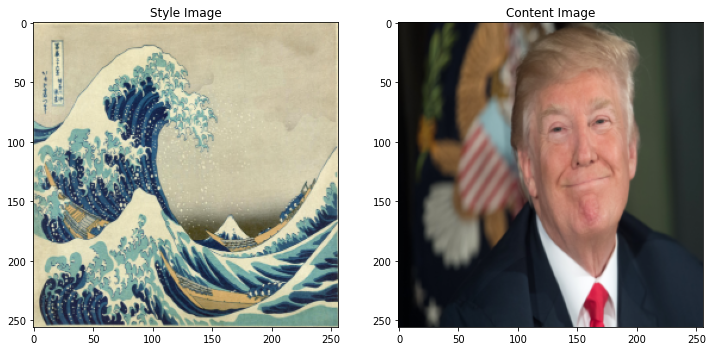

In [0]:
def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = image.numpy().transpose([1,2,0])
    plt.imshow(image / np.max(image))
    if title is not None:
        plt.title(title)

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
imshow(style_img.data, title='Style Image')
plt.subplot(1,2,2)
imshow(content_img.data, title='Content Image')

### Define Style Transfer Losses

As shown in the lecture, we define two loss functions: content and style losses.

Content loss is simply a pointwise mean squared error of high-level features while style loss is the error between gram matrices of intermediate feature layers.

To obtain the feature representations we use a pre-trained VGG19 network.

In [0]:
import torchvision.models as models

cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
class FeautreExtractor(nn.Module):
    def __init__(self, cnn, replace_maxpool=False):
        super(FeautreExtractor, self).__init__()
        chunks_end_indices = [1, 6, 11, 20, 29]

        self.blocks = nn.ModuleList([])

        current_block_layers = []

        for idx, layer in cnn._modules.items():
            idx = int(idx)

            if replace_maxpool and isinstance(layer, nn.MaxPool2d):
                layer = nn.AvgPool2d(2)

            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)

            current_block_layers += [layer]

            if idx in chunks_end_indices:
                self.blocks += [nn.Sequential(*current_block_layers)]
                current_block_layers = []
        
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        self.register_buffer('mean', mean)

        std = torch.FloatTensor([0.229, 0.224, 0.225])
        self.register_buffer('std', std)

        # TODO:
        # Task 1) slice the network into chunks and store them into nn.ModuleList
        # chunk_0: layers 0-1, chunk_1: layers 2-6, ..., chunk_4: layers 21-29
        #
        # Task 2) Also implement replace_maxpool option, which replaces each MaxPool2d layer with AvgPool2d

    def forward(self, input):
        # TODO: sequentially forward through all chunks and return a list of outputs from each chunk
        # Do not forget to normalize the input! Preprocessing used for PyTorch pretrained nets:
        #   mean=[0.485, 0.456, 0.406],
        #   std=[0.229, 0.224, 0.225]

        features = []
        output = (input - self.mean[None, :, None, None]) / self.std[None, :, None, None]

        for block in self.blocks:
            output = block(output)
            features += [output]
          
        return features

Gram matrices are uncentered correlations (second momentum) of the feature maps, calculated w.r.t channels

\begin{align}
    & F \in \mathbb{R}^{C \times HW} \\
    & \mathcal{L}_\text{Gram} = \frac{1}{CHW} \Big( F \times F^T \Big)
\end{align}

In [0]:
def gram_matrix(input):
    # TODO: calculate Gram matrices using features
    _, c, h, w = input.shape
    input = input.view(c, h*w)
    output = torch.mm(input, input.t())
    output = output / (c * h * w)

    return output

### Style transfer pipeline

We can now define a unified "model" that computes all the losses on the image triplet (content image, style image, optimized image) so that we could optimize them with backprop (over image pixels).

In [0]:
content_weight = 1             # coefficient for content loss
style_weight = 1000000         # coefficient for style loss
content_layers = [3]           # use these layers for content loss
style_layers = [0, 1, 2, 3, 4] # use these layers for style loss

In [0]:
model = FeautreExtractor(cnn, replace_maxpool=False)
# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()

target_features = model(style_img)

target_gram_matrices = []

for feats in [target_features[i] for i in style_layers]:
    target_gram_matrices += [gram_matrix(feats)]

target_features = model(content_img)

target_content_feats = [target_features[i] for i in content_layers]

### Optimization

We can now optimize both style and content loss over input image.

In [0]:
input_image = content_img.clone().data
#input_image = torch.randn_like(input_image) * 0.02 # Try using a random initialization and see the result!
input_image.requires_grad = True
optimizer = torch.optim.LBFGS([input_image])

criterion = nn.MSELoss()

In [0]:
num_steps = 300

for i in range(num_steps):

    def closure():
        # correct the values of updated input image
        input_image.data.clamp_(0, 1)

        # TODO: forward pass an input_image though the feature_extractor and calculate content and style losses
        # content and style losses are MSE errors between features and Gram matrices respectively

        pred_features = model(input_image)

        # Calculate content loss
        pred_content_feats = [pred_features[i] for i in content_layers]

        loss_content = 0
        
        for feats, target_feats in zip(pred_content_feats, target_content_feats):
            loss_content += criterion(feats, target_feats.detach())

        # Calculate style loss
        loss_style = 0

        pred_style_feats = [pred_features[i] for i in style_layers]

        for feats, target_gram_matrix in zip(pred_style_feats, target_gram_matrices):
            pred_gram_matrix = gram_matrix(feats)

            loss_style += criterion(pred_gram_matrix, target_gram_matrix.detach())
        
        loss = loss_content * content_weight + loss_style * style_weight

        optimizer.zero_grad()
        loss.backward()

        return loss
    
    optimizer.step(closure)

# a last correction...
input_image = input_image.data.clamp_(0, 1)

### Final image

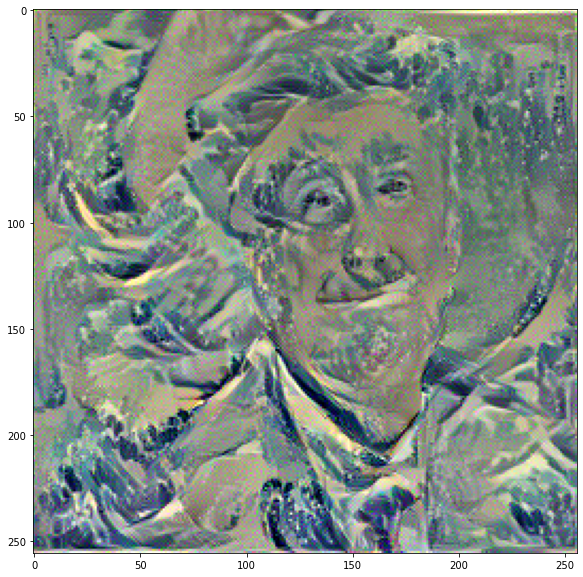

In [0]:
plt.figure(figsize=[10,10])
plt.imshow(input_image.cpu().data.numpy()[0].transpose(1, 2, 0))
plt.show()